In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth

import networkx as nx

Загрузка данных

In [137]:
df = pd.read_csv('Market_Basket_Optimisation.csv', header=None)
df.head()

# Преобразуем CSV в список транзакций
transactions = df.values.tolist()
transactions = [[item for item in row if isinstance(item, str)] for row in transactions]

print("Пример транзакции:", transactions[0])
print("Всего транзакций:", len(transactions))

Пример транзакции: ['shrimp', 'almonds', 'avocado', 'vegetables mix', 'green grapes', 'whole weat flour', 'yams', 'cottage cheese', 'energy drink', 'tomato juice', 'low fat yogurt', 'green tea', 'honey', 'salad', 'mineral water', 'salmon', 'antioxydant juice', 'frozen smoothie', 'spinach', 'olive oil']
Всего транзакций: 7501


Описание данных

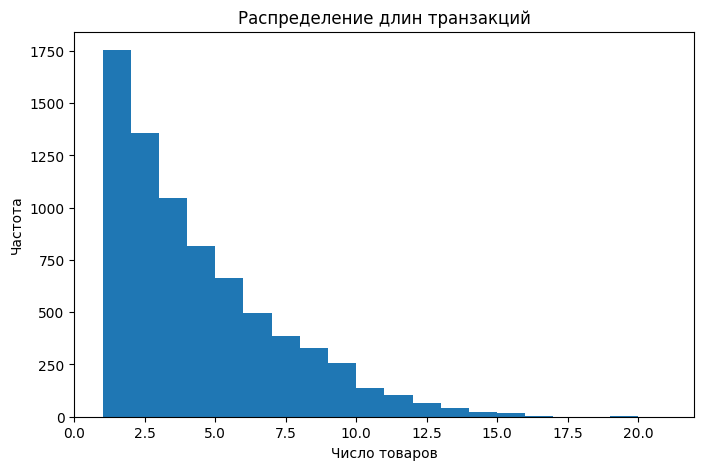

Количество уникальных товаров: 120
Первые 20 товаров: [' asparagus', 'almonds', 'antioxydant juice', 'asparagus', 'avocado', 'babies food', 'bacon', 'barbecue sauce', 'black tea', 'blueberries', 'body spray', 'bramble', 'brownies', 'bug spray', 'burger sauce', 'burgers', 'butter', 'cake', 'candy bars', 'carrots']


In [138]:
transaction_lengths = [len(t) for t in transactions]

plt.figure(figsize=(8,5))
plt.hist(transaction_lengths, bins=range(1, max(transaction_lengths)+2))
plt.title("Распределение длин транзакций")
plt.xlabel("Число товаров")
plt.ylabel("Частота")
plt.show()

# Уникальные товары
unique_items = sorted({item for t in transactions for item in t})
print("Количество уникальных товаров:", len(unique_items))
print("Первые 20 товаров:", unique_items[:20])

Преобразование данных в бинарный формат

In [139]:
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
data = pd.DataFrame(te_ary, columns=te.columns_)

print("Размер бинарной матрицы:", data.shape)
data.head()

Размер бинарной матрицы: (7501, 120)


,asparagus,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,...,turkey,vegetables mix,water spray,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,False,True,True,False,True,False,False,False,False,False,...,False,True,False,False,True,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


Apriori

In [140]:
min_support_ap = 0.02

frequent_ap = apriori(data, min_support=min_support_ap, use_colnames=True)
frequent_ap['length'] = frequent_ap['itemsets'].apply(len)

print("Частые наборы (Apriori):", len(frequent_ap))
frequent_ap.head()

rules_ap = association_rules(frequent_ap, metric='confidence', min_threshold=0.3)
rules_ap.head()

Частые наборы (Apriori): 103


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(burgers),(eggs),0.087188,0.179709,0.028796,0.330275,1.837830,1.0,0.013128,1.224818,0.499424,0.120941,0.183552,0.245256
1,(cake),(mineral water),0.081056,0.238368,0.027463,0.338816,1.421397,1.0,0.008142,1.151921,0.322617,0.094064,0.131885,0.227014
2,(chicken),(mineral water),0.059992,0.238368,0.022797,0.380000,1.594172,1.0,0.008497,1.228438,0.396502,0.082729,0.185958,0.237819
3,(chocolate),(mineral water),0.163845,0.238368,0.052660,0.321400,1.348332,1.0,0.013604,1.122357,0.308965,0.150648,0.109018,0.271158
4,(cooking oil),(mineral water),0.051060,0.238368,0.020131,0.394256,1.653978,1.0,0.007960,1.257349,0.416672,0.074752,0.204676,0.239354


Анализ лучших правил Apriori

In [141]:
rules_ap['antecedents_str'] = rules_ap['antecedents'].apply(lambda x: ', '.join(list(x)))
rules_ap['consequents_str'] = rules_ap['consequents'].apply(lambda x: ', '.join(list(x)))

print("ТОП-10 правил по лифту:")
rules_ap.sort_values(by='lift', ascending=False).head(10)

ТОП-10 правил по лифту:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,antecedents_str,consequents_str
8,(ground beef),(spaghetti),0.098254,0.174110,0.039195,0.398915,2.291162,1.0,0.022088,1.373997,0.624943,0.168096,0.272197,0.312015,ground beef,spaghetti
18,(olive oil),(spaghetti),0.065858,0.174110,0.022930,0.348178,1.999758,1.0,0.011464,1.267048,0.535186,0.105651,0.210764,0.239939,olive oil,spaghetti
14,(soup),(mineral water),0.050527,0.238368,0.023064,0.456464,1.914955,1.0,0.011020,1.401255,0.503221,0.086760,0.286354,0.276610,soup,mineral water
0,(burgers),(eggs),0.087188,0.179709,0.028796,0.330275,1.837830,1.0,0.013128,1.224818,0.499424,0.120941,0.183552,0.245256,burgers,eggs
11,(olive oil),(mineral water),0.065858,0.238368,0.027596,0.419028,1.757904,1.0,0.011898,1.310962,0.461536,0.099759,0.237201,0.267400,olive oil,mineral water
19,(tomatoes),(spaghetti),0.068391,0.174110,0.020931,0.306043,1.757755,1.0,0.009023,1.190117,0.462740,0.094465,0.159746,0.213129,tomatoes,spaghetti
7,(ground beef),(mineral water),0.098254,0.238368,0.040928,0.416554,1.747522,1.0,0.017507,1.305401,0.474369,0.138413,0.233952,0.294127,ground beef,mineral water
4,(cooking oil),(mineral water),0.051060,0.238368,0.020131,0.394256,1.653978,1.0,0.007960,1.257349,0.416672,0.074752,0.204676,0.239354,cooking oil,mineral water
2,(chicken),(mineral water),0.059992,0.238368,0.022797,0.380000,1.594172,1.0,0.008497,1.228438,0.396502,0.082729,0.185958,0.237819,chicken,mineral water
6,(frozen vegetables),(mineral water),0.095321,0.238368,0.035729,0.374825,1.572463,1.0,0.013007,1.218270,0.402413,0.119911,0.179164,0.262357,frozen vegetables,mineral water


Алгоритм Apriori нашёл 103 частых набора и на их основе сгенерировал набор ассоциативных правил.

В ТОП-10 по лифту попадают правила вида
ground beef → spaghetti, olive oil → spaghetti, soup → mineral water, burgers → eggs и т.п.

Общая особенность: в правой части правил часто встречаются одни и те же товары (spaghetti, mineral water, eggs). Значения лифта > 1 для всех приведённых правил означают существенную положительную связь: совместная покупка этих товаров происходит чаще, чем можно ожидать при независимости.

FPG

In [142]:
min_support_fpg = 0.02

frequent_fpg = fpgrowth(data, min_support=min_support_fpg, use_colnames=True)
frequent_fpg['length'] = frequent_fpg['itemsets'].apply(len)

print("Частые наборы (FPG):", len(frequent_fpg))

rules_fpg = association_rules(frequent_fpg, metric='confidence', min_threshold=0.3)
rules_fpg['antecedents_str'] = rules_fpg['antecedents'].apply(lambda x: ', '.join(list(x)))
rules_fpg['consequents_str'] = rules_fpg['consequents'].apply(lambda x: ', '.join(list(x)))

print("ТОП-10 правил по лифту (FPG):")
rules_fpg.sort_values(by='lift', ascending=False).head(10)

Частые наборы (FPG): 103
ТОП-10 правил по лифту (FPG):


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,antecedents_str,consequents_str
18,(ground beef),(spaghetti),0.098254,0.174110,0.039195,0.398915,2.291162,1.0,0.022088,1.373997,0.624943,0.168096,0.272197,0.312015,ground beef,spaghetti
3,(olive oil),(spaghetti),0.065858,0.174110,0.022930,0.348178,1.999758,1.0,0.011464,1.267048,0.535186,0.105651,0.210764,0.239939,olive oil,spaghetti
8,(soup),(mineral water),0.050527,0.238368,0.023064,0.456464,1.914955,1.0,0.011020,1.401255,0.503221,0.086760,0.286354,0.276610,soup,mineral water
5,(burgers),(eggs),0.087188,0.179709,0.028796,0.330275,1.837830,1.0,0.013128,1.224818,0.499424,0.120941,0.183552,0.245256,burgers,eggs
2,(olive oil),(mineral water),0.065858,0.238368,0.027596,0.419028,1.757904,1.0,0.011898,1.310962,0.461536,0.099759,0.237201,0.267400,olive oil,mineral water
15,(tomatoes),(spaghetti),0.068391,0.174110,0.020931,0.306043,1.757755,1.0,0.009023,1.190117,0.462740,0.094465,0.159746,0.213129,tomatoes,spaghetti
17,(ground beef),(mineral water),0.098254,0.238368,0.040928,0.416554,1.747522,1.0,0.017507,1.305401,0.474369,0.138413,0.233952,0.294127,ground beef,mineral water
11,(cooking oil),(mineral water),0.051060,0.238368,0.020131,0.394256,1.653978,1.0,0.007960,1.257349,0.416672,0.074752,0.204676,0.239354,cooking oil,mineral water
13,(chicken),(mineral water),0.059992,0.238368,0.022797,0.380000,1.594172,1.0,0.008497,1.228438,0.396502,0.082729,0.185958,0.237819,chicken,mineral water
10,(frozen vegetables),(mineral water),0.095321,0.238368,0.035729,0.374825,1.572463,1.0,0.013007,1.218270,0.402413,0.119911,0.179164,0.262357,frozen vegetables,mineral water


Для тех же параметров поддержки и достоверности алгоритм FPGrowth нашёл то же количество частых наборов (103), что и Apriori.

ТОП-10 правил по лифту практически совпадает с результатами Apriori — те же пары товаров (ground beef → spaghetti, olive oil → spaghetti, soup → mineral water и др.). Это показывает, что оба алгоритма выявляют одинаковые закономерности при одинаковых параметрах

Минимальная поддержка наборов разной длины

   length   support
0       1  0.005199
1       2  0.005066
2       3  0.005066


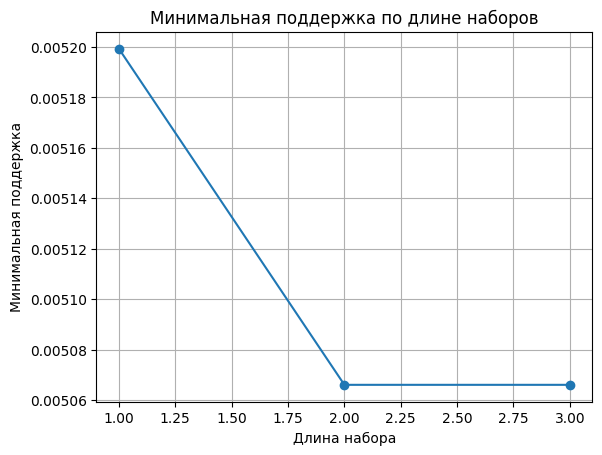

In [143]:
frequent_low = fpgrowth(data, min_support=0.005, use_colnames=True)
frequent_low['length'] = frequent_low['itemsets'].apply(len)

min_support_by_len = (
    frequent_low.groupby('length')['support'].min().reset_index().sort_values('length')
)

print(min_support_by_len)

plt.plot(min_support_by_len['length'], min_support_by_len['support'], marker='o')
plt.title("Минимальная поддержка по длине наборов")
plt.xlabel("Длина набора")
plt.ylabel("Минимальная поддержка")
plt.grid()
plt.show()

Эксперименты с параметрами

    min_support  min_conf  n_itemsets  n_rules
0          0.01       0.3         257       63
1          0.01       0.5         257        2
2          0.01       0.7         257        0
3          0.02       0.3         103       20
4          0.02       0.5         103        0
5          0.02       0.7         103        0
6          0.03       0.3          54        7
7          0.03       0.5          54        0
8          0.03       0.7          54        0
9          0.05       0.3          28        2
10         0.05       0.5          28        0
11         0.05       0.7          28        0


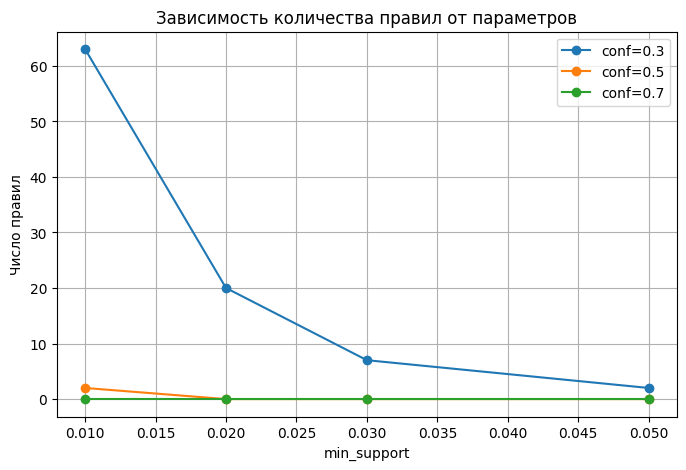

In [144]:
support_values = [0.01, 0.02, 0.03, 0.05]
conf_values = [0.3, 0.5, 0.7]

results = []

for s in support_values:
    freq = fpgrowth(data, min_support=s, use_colnames=True)
    for c in conf_values:
        r = association_rules(freq, metric='confidence', min_threshold=c)
        results.append({
            'min_support': s,
            'min_conf': c,
            'n_itemsets': len(freq),
            'n_rules': len(r)
        })

results_df = pd.DataFrame(results)
print(results_df)

plt.figure(figsize=(8,5))
for c in conf_values:
    sub = results_df[results_df['min_conf'] == c]
    plt.plot(sub['min_support'], sub['n_rules'], marker='o', label=f'conf={c}')

plt.legend()
plt.xlabel("min_support")
plt.ylabel("Число правил")
plt.title("Зависимость количества правил от параметров")
plt.grid()
plt.show()

При min_support = 0.01 и confidence = 0.3 алгоритм строит максимум правил (63).

При увеличении min_support количество правил быстро падает: при 0.02 остаётся 20 правил, при 0.03 – всего 7, при 0.05 – уже 3 правила.

При более жёстких требованиях к confidence (0.5 и 0.7) число правил почти обнуляется — большинство сочетаний просто не проходят порог достоверности.

Вывод:

параметр поддержки контролирует «масштаб» поиска — чем он выше, тем меньше редких закономерностей остаётся, параметр достоверности задаёт строгость правила — при высоком confidence остаются только самые надёжные, но очень немногие связи.

С практической точки зрения, разумный выбор параметров — компромисс между количеством и качеством правил (например, support ≈ 0.02–0.03, confidence ≈ 0.3–0.4).

Граф

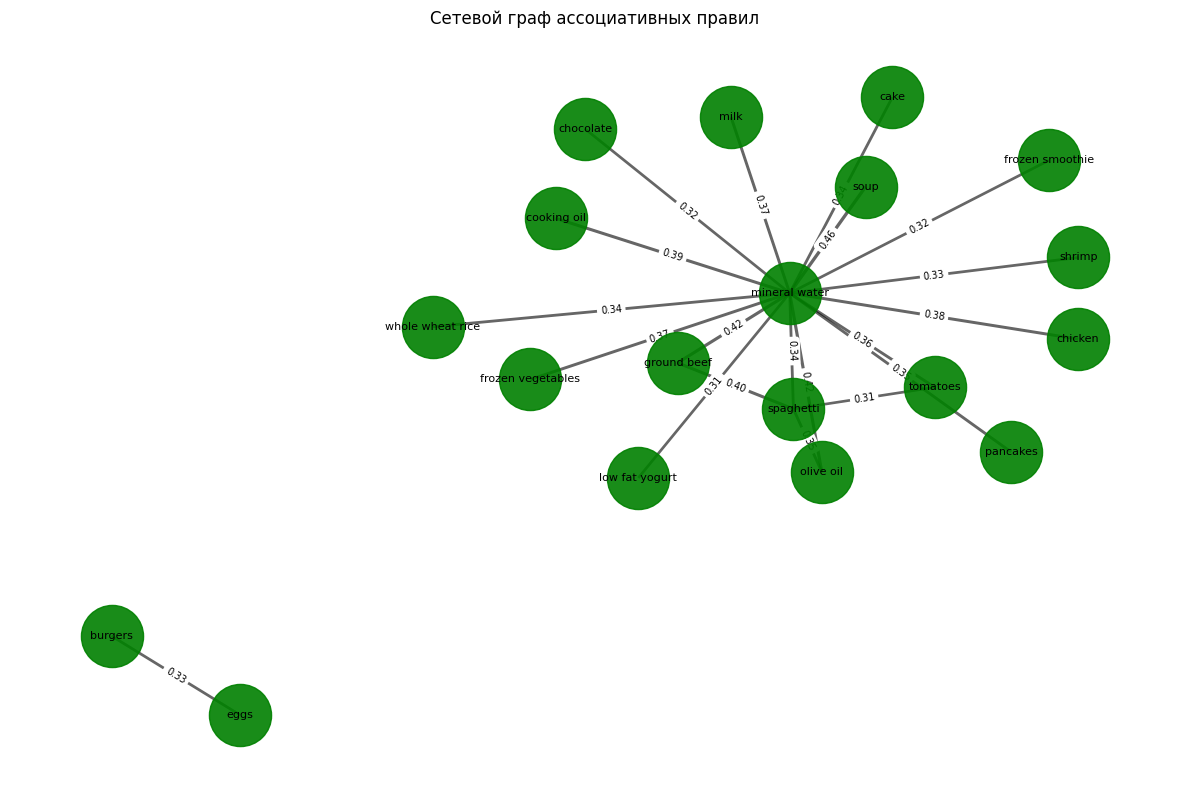

In [ ]:
rules_graph = rules_fpg.sort_values(by='confidence', ascending=False).head(20)

G = nx.Graph()

for _, row in rules_graph.iterrows():
    ant = row["antecedents_str"]
    cons = row["consequents_str"]

    G.add_node(ant)
    G.add_node(cons)

for _, row in rules_graph.iterrows():
    ant = row["antecedents_str"]
    cons = row["consequents_str"]
    conf = row["confidence"]

    if G.has_edge(ant, cons):
        G[ant][cons]["weight"] = max(G[ant][cons]["weight"], conf)
    else:
        G.add_edge(ant, cons, weight=conf)

pos = nx.spring_layout(G, k=0.8, iterations=100, seed=42)

plt.figure(figsize=(12, 8))

edges = G.edges()
weights = [G[u][v]["weight"] for u, v in edges]

nx.draw_networkx_edges(G, pos, edgelist=edges, width=[1 + 3 * w for w in weights], alpha=0.6)

nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="green", alpha=0.9)

nx.draw_networkx_labels(G, pos, font_size=8)

edge_labels = nx.get_edge_attributes(G, "weight")
edge_labels = {k: f"{v:.2f}" for k, v in edge_labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, label_pos=0.5)

plt.title("Сетевой граф ассоциативных правил")
plt.tight_layout()
plt.axis("off")
plt.show()

Видно, что “mineral water” является центральным узлом: от него расходится наибольшее количество связей. Это означает, что минеральную воду часто покупают вместе с широким набором других товаров (soup, chicken, tomatoes, cooking oil, frozen vegetables и др.).

Отдельный кластер образуют, например, burgers и eggs — это изолированное правило, не связанное с «минеральной водой» и другими продуктами.

Такой граф позволяет:

увидеть центральные товары, вокруг которых строятся основные комбинации;

визуально выделить кластеры взаимосвязанных продуктов;

быстро заметить правила с высокой достоверностью (толстые рёбра).

Своя визуализация:
    - по оси X: поддержка правила (support) — насколько часто оно встречается
    - по оси Y: достоверность правила (confidence) — насколько надёжно правило
    - размер точки: lift — мера "силы связи" между товарами
Так на одном графике можно сразу увидеть:
    - редкие/частые правила (по X),
    - надёжные/ненадёжные (по Y),
    - насколько правило нетривиально (по размеру точки).

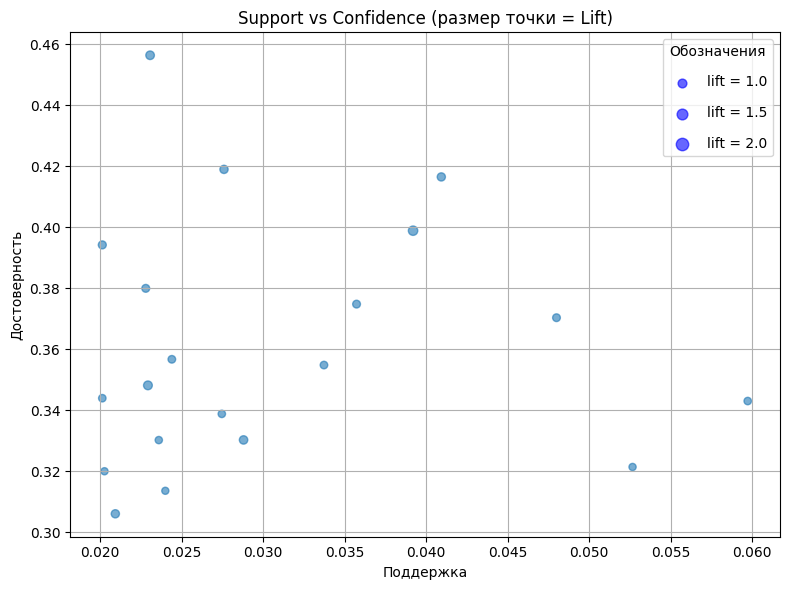

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(rules_fpg['support'], rules_fpg['confidence'], s=rules_fpg['lift']*20, alpha=0.6)

plt.xlabel("Поддержка")
plt.ylabel("Достоверность")
plt.title("Support vs Confidence (размер точки = Lift)")
plt.grid()
lift_levels = [1.0, 1.5, 2.0]

for lvl in lift_levels:
    plt.scatter([], [], s=lvl * 40, alpha=0.6, color='blue', label=f"lift = {lvl}")

plt.legend(scatterpoints=1, frameon=True, labelspacing=1.2, title="Обозначения")

plt.tight_layout()
plt.show()